In [38]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

In [ ]:
# Function for preprocessing the data for the model

def preprocess_with_time_features(file_path):
    df = pd.read_csv(file_path)
    
    # Remove duplicates
    df = df.drop_duplicates(subset=['date'], keep='last')
    
    # Replace values
    df.replace(to_replace='-', value=np.nan, inplace=True)
    df.snow_depth_cm = df.snow_depth_cm.replace(to_replace='-1', value='0')

    # Delete rows where snow_depth is null
    df = df.dropna(subset=['snow_depth_cm'])

    # Convert to numeric
    df['avg_temp_c'] = pd.to_numeric(df['avg_temp_c'], errors='coerce')
    df['snow_depth_cm'] = pd.to_numeric(df['snow_depth_cm'], errors='coerce')
    df['uv_index'] = pd.to_numeric(df['uv_index'], errors='coerce')
    
    # Create lag features
    df['snow_depth_1d_ago'] = df['snow_depth_cm'].shift(1)
    df['snow_depth_7d_ago'] = df['snow_depth_cm'].shift(7)
    df['snow_depth_365d_ago'] = df['snow_depth_cm'].shift(365)

    # Convert date string to datetime object
    df['date'] = pd.to_datetime(df['date'])
    
    # Extract time-based features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_year'] = df['date'].dt.dayofyear
    
    # Drop rows with missing target values
    df = df.dropna(subset=['snow_depth_cm'])
    
    return df

In [40]:
# Combine 4 location datasets for training the model
datasets = [
    'data_by_location/Messila_data.csv',
    'data_by_location/Purnu_data.csv',
    'data_by_location/Ruunarinteet_data.csv',
    'data_by_location/Kasurila_data.csv'
]

all_data = []

for dataset in datasets:
    try:
        df = preprocess_with_time_features(dataset)
        all_data.append(df)
    except Exception as e:
        print(f"Error processing {dataset}: {e}")

combined_df = pd.concat(all_data)

In [41]:
combined_df.columns

Index(['date', 'snow_depth_cm', 'avg_temp_c', 'uv_index', 'cloud_cover_rate',
       'cloud_cover', 'location', 'snow_depth_1d_ago', 'snow_depth_7d_ago',
       'snow_depth_365d_ago', 'year', 'month', 'day', 'day_of_year'],
      dtype='object')

In [42]:
combined_df.sample(15)

,date,snow_depth_cm,avg_temp_c,uv_index,cloud_cover_rate,cloud_cover,location,snow_depth_1d_ago,snow_depth_7d_ago,snow_depth_365d_ago,year,month,day,day_of_year
2733,2010-09-02,0.0,8.6,NaN,0.0,Clear,Kasurila,0.0,0.0,0.0,2010,9,2,245
477,2004-06-29,0.0,15.7,0.4,NaN,NaN,Messila,0.0,0.0,0.0,2004,6,29,181
6614,2021-04-18,0.0,10.0,0.9,0.0,Clear,Messila,0.0,0.0,0.0,2021,4,18,108
1839,2008-03-22,33.0,-9.2,0.3,0.0,Clear,Kasurila,33.0,33.0,27.0,2008,3,22,82
3524,2012-11-01,7.0,2.1,0.1,5.0,Partly cloudy,Ruunarinteet,7.0,0.0,0.0,2012,11,1,306
1120,2006-04-03,43.0,-0.6,0.2,NaN,NaN,Ruunarinteet,43.0,46.0,23.0,2006,4,3,93
3943,2013-12-25,0.0,3.8,0.0,7.0,Mostly cloudy,Purnu,0.0,2.0,25.0,2013,12,25,359
3874,2013-10-17,0.0,0.1,0.1,7.0,Mostly cloudy,Purnu,0.0,0.0,0.0,2013,10,17,290
7179,2022-11-04,0.0,4.0,0.1,8.0,Cloudy,Purnu,0.0,0.0,0.0,2022,11,4,308
3722,2013-05-18,0.0,15.3,1.1,7.0,Mostly cloudy,Kasurila,0.0,0.0,0.0,2013,5,18,138


In [43]:
combined_df.dtypes

date                   datetime64[ns]
snow_depth_cm                 float64
avg_temp_c                    float64
uv_index                      float64
cloud_cover_rate              float64
cloud_cover                    object
location                       object
snow_depth_1d_ago             float64
snow_depth_7d_ago             float64
snow_depth_365d_ago           float64
year                            int32
month                           int32
day                             int32
day_of_year                     int32
dtype: object

In [44]:
# Remove duplicates (if same location and date)
combined_df = combined_df.drop_duplicates(subset=['date', 'location'], keep='last')

In [45]:
combined_df.shape

(30076, 14)

In [46]:
combined_df.location.value_counts()

location
Ruunarinteet    8021
Messila         7843
Purnu           7163
Kasurila        7049
Name: count, dtype: int64

In [47]:
# Create an XGBoost regressor model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

X = combined_df[['avg_temp_c', 
                 'cloud_cover_rate',
                 'uv_index', 
                 'snow_depth_1d_ago', 
                 'snow_depth_7d_ago', 
                 'snow_depth_365d_ago', 
                 'year', 
                 'month', 
                 'day', 
                 'day_of_year']]  # Features 

y = combined_df['snow_depth_cm']  # Target variable (snow depth)

# Split into training (80%) and test (20%) data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, 'snow_depth_time_model.joblib')

['snow_depth_time_model.joblib']

In [48]:
# Calculate predictions for testing the model
predictions = model.predict(X_test)

In [49]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.7393424588231221
Mean Squared Error: 3.407291535851011
Root Mean Squared Error: 1.8458850277985925


In [ ]:
# Testing model with another location (not included in training data)

test_df = preprocess_with_time_features('data_by_location/ruka_data.csv')

X = test_df[['avg_temp_c', 
                 'cloud_cover_rate',
                 'uv_index', 
                 'snow_depth_1d_ago', 
                 'snow_depth_7d_ago', 
                 'snow_depth_365d_ago', 
                 'year', 
                 'month', 
                 'day', 
                 'day_of_year']]  # Features 

y = test_df['snow_depth_cm']  # Target variable (snow depth)

# Calculate predictions for testing the model
pred = model.predict(X)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y, pred)
print(f"Mean Absolute Error for Ruka data: {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, pred)
print(f"Mean Squared Error for Ruka data: {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error for Ruka data: {rmse}")

Mean Absolute Error for Ruka data: 0.9452060900359779
Mean Squared Error Ruka data: 3.592496080691555
Root Mean Squared Error Ruka data: 1.895388108196196


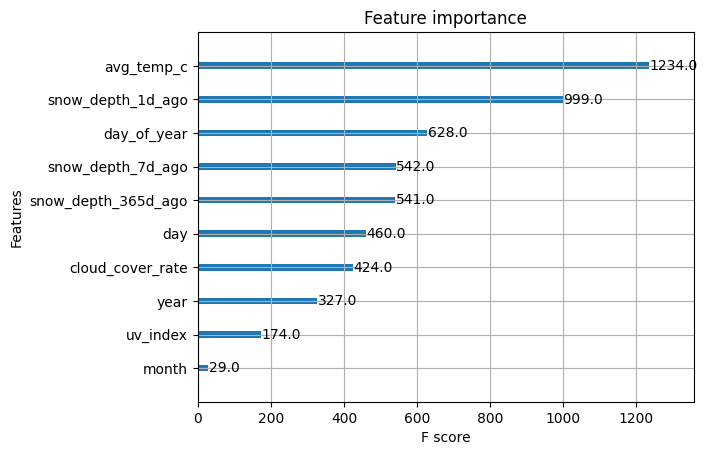

In [51]:
# Plot feature importance
xgb.plot_importance(model)
plt.show()

In [52]:
# Function to predict future years
def predict_future_snow_depth(model, start_date, days=365, location_data=None):
    """
    Predict snow depth for future dates
    
    Parameters:
    - model: Trained model
    - start_date: Start date for predictions (string YYYY-MM-DD or datetime)
    - days: Number of days to predict forward
    - location_data: Sample data from a location to use as base values
    
    Returns:
    - DataFrame with dates and predicted snow depths
    """
    if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
    
    # Create date range
    future_dates = [start_date + timedelta(days=i) for i in range(days)]
    future_df = pd.DataFrame({'date': future_dates})

    if location_data is not None:
        past_snow_data = location_data[['date', 'snow_depth_cm']].copy()
    
        past_snow_data['snow_depth_1d_ago'] = past_snow_data['snow_depth_cm'].shift(1)
        past_snow_data['snow_depth_7d_ago'] = past_snow_data['snow_depth_cm'].shift(7)
        past_snow_data['snow_depth_365d_ago'] = past_snow_data['snow_depth_cm'].shift(365)
    
        future_df = future_df.merge(past_snow_data[['date', 'snow_depth_1d_ago', 'snow_depth_7d_ago', 'snow_depth_365d_ago']], 
                                on='date', how='left')
    
    # Extract time features
    future_df['year'] = future_df['date'].dt.year
    future_df['month'] = future_df['date'].dt.month
    future_df['day'] = future_df['date'].dt.day
    future_df['day_of_year'] = future_df['date'].dt.dayofyear
    
    # Generate weather features based on historical averages by day of year
    if location_data is not None:
        # Group location data by day of year and get averages
        daily_averages = location_data.groupby('day_of_year').agg({
            'avg_temp_c': 'mean',
            'uv_index': 'mean',
            'cloud_cover_rate': 'mean'
        }).reset_index()
        
        # Merge with future dates
        future_df = future_df.merge(daily_averages, on='day_of_year', how='left')

        # For days not in historical data, use nearest day
        future_df = future_df.ffill().bfill()
    else:
        # If no location data is provided, use seasonal patterns
        # This is simplified - would be better with actual historical weather data
        future_df['month_rad'] = future_df['month'] * 2 * np.pi / 12
        
        # Temperature follows seasonal cycle (simplified model)
        # Northern hemisphere: coldest in Jan/Feb, warmest in Jul/Aug
        future_df['avg_temp_c'] = -10 * np.cos(future_df['month_rad']) + 5
        
        # UV follows similar seasonal pattern
        future_df['uv_index'] = 3 * np.cos((future_df['month_rad'] + np.pi)) + 3
        
        # Cloud cover (simplified)
        future_df['cloud_cover_rate'] = 0.5 + 0.2 * np.sin(future_df['month_rad'])
    
    # Prepare features for prediction in the same format as training data
    X_future = future_df[['avg_temp_c', 
                          'cloud_cover_rate',
                          'uv_index', 
                          'snow_depth_1d_ago', 
                          'snow_depth_7d_ago', 
                          'snow_depth_365d_ago', 
                          'year', 
                          'month', 
                          'day', 
                          'day_of_year']]
    
    # Make predictions
    future_df['predicted_snow_depth'] = model.predict(X_future)
    
    # Ensure non-negative snow depths
    future_df['predicted_snow_depth'] = future_df['predicted_snow_depth'].clip(lower=0)
    
    return future_df[['date', 
                      'predicted_snow_depth', 
                      'avg_temp_c', 
                      'uv_index', 
                      'cloud_cover_rate']]

In [53]:
# Create prediction files for locations

def create_prediction_files(locations):
    # Load the trained model
    trained_model = joblib.load('snow_depth_time_model.joblib')

    for location in locations:
        location_df = preprocess_with_time_features(f'data_by_location/{location}_data.csv')

        start_prediction_date = '2005-01-01'
        future_predictions = predict_future_snow_depth(
            model=trained_model,
            start_date=start_prediction_date,
            days=365*40,
            location_data=location_df
        )
        future_predictions['location'] = location

        future_predictions.to_csv(f'snow_depth_predictions_{location}_2025.csv', index=False)
        print(f'Future predictions for {location} saved csv-file')
